## *Step 1: Import Modules*

In [4]:
!pip3 install graphviz
!pip3 install ann_visualizer

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [5]:
import numpy as np
import pandas as pd
import os
from glob import glob
import itertools
import fnmatch
import random
import matplotlib.pylab as plt
import seaborn as sns
import cv2
from PIL import Image
from ann_visualizer.visualize import ann_viz;

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
%matplotlib inline

## *Step 2: Explore Data*

In [6]:
# Adding path of all the images together 
imagePatches = glob('/kaggle/input/breast-histopathology-images/**/*.png', recursive=True)
for filename in imagePatches[0:5]:
    print(filename)

/kaggle/input/breast-histopathology-images/10295/0/10295_idx5_x1351_y1101_class0.png
/kaggle/input/breast-histopathology-images/10295/0/10295_idx5_x1501_y501_class0.png
/kaggle/input/breast-histopathology-images/10295/0/10295_idx5_x1501_y1101_class0.png
/kaggle/input/breast-histopathology-images/10295/0/10295_idx5_x451_y901_class0.png
/kaggle/input/breast-histopathology-images/10295/0/10295_idx5_x801_y451_class0.png


(-0.5, 49.5, 49.5, -0.5)

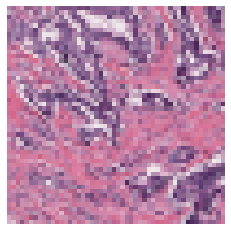

In [7]:
image_sample = "/kaggle/input/breast-histopathology-images/12935/1/12935_idx5_x1301_y1251_class1.png"
dsize=(50,50)

image = cv2.imread(image_sample)
image = cv2.resize(image, dsize)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.axis('off')


## *Step 3: Preprocess Data*

In [8]:
resized_images,labels_arr = [],[]
dsize=(50,50)
    
for img in imagePatches[0:20000]:
    full_size_image = cv2.imread(img)
    resized_images.append(cv2.resize(full_size_image, dsize, interpolation=cv2.INTER_CUBIC))
    labels_arr.append(int(img[-5]))

In [9]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(len(a)-np.sum(b)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(resized_images,labels_arr)

Total number of images: 20000
Number of IDC(-) Images: 13351
Number of IDC(+) Images: 6649
Image shape (Width, Height, Channels): (50, 50, 3)


In [10]:
X=np.array(resized_images)
Y=pd.Series(labels_arr) 
X=X/255.0
 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, )

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (16000, 50, 50, 3)
Testing Data Shape: (4000, 50, 50, 3)


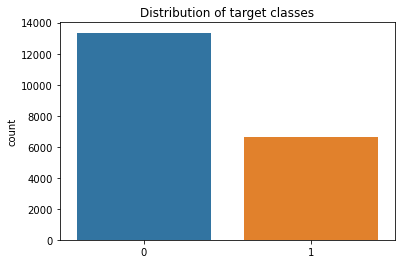

In [11]:
plt.title("Distribution of target classes")
sns.countplot(Y) 

In [12]:
# Make Data 1D for compatability upsampling methods
image_shape = 50*50*3

X_train = X_train.reshape(X_train.shape[0], image_shape)
X_test = X_test.reshape(X_test.shape[0], image_shape)


In [13]:
print("Shape of flattened training data:",X_train.shape,"\nShape of flatened testing data: ",X_test.shape)

Shape of flattened training data: (16000, 7500) 
Shape of flatened testing data:  (4000, 7500)


In [14]:
# Deal with imbalanced class sizes below

# from imblearn.over_sampling import RandomOverSampler 
from imblearn.under_sampling import RandomUnderSampler

# Ros = RandomOverSampler(sampling_strategy='auto') 
Rus = RandomUnderSampler(sampling_strategy='auto')

X_trainRusFlat, Y_trainRus = Rus.fit_sample(X_train, Y_train)
X_testRusFlat, Y_testRus = Rus.fit_sample(X_test, Y_test)

#Reshape the images
X_trainRus = X_trainRusFlat.reshape(len(X_trainRusFlat),50,50,3)
X_testRus = X_testRusFlat.reshape(len(X_testRusFlat),50,50,3)

# Encode labels
Y_trainRus = to_categorical(Y_trainRus, num_classes = 2)
Y_testRus = to_categorical(Y_testRus, num_classes = 2)


In [15]:
print("New shape of Train data =",X_trainRus.shape)
print("New shape of Test data =",X_testRus.shape)

New shape of Train data = (10592, 50, 50, 3)
New shape of Test data = (2706, 50, 50, 3)


## *Step 4: Define Helper Functions for the Classification Task*

In [16]:
# Helper Functions  Learning Curves and Confusion Matrix 

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotLearningCurve():
    
    plt.figure(figsize=(10,6))
    metrics = np.load('logs.npy', allow_pickle=True)[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')
    
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_learning_curve(history):
    
    plt.figure(figsize=(10,6))
    
    #model accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    # model loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
def plot_confusion_matrix(cm, normalize=False, cmap=plt.cm.Blues):
    title='Confusion matrix'
    classes = {0: 'IDC(-)', 1: 'IDC(+)'}
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## *Step 5: Evaluate Classification Models*

In [17]:
def build_base_CNN(num_classes=2, input_shape = (50,50, 3)):
        
    model = Sequential()
    model.add(Conv2D(32, (5, 5), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(32, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='sigmoid'))
    
    return model

In [18]:
def build_final_CNN(num_classes=2, input_shape = (50,50, 3)):
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3, 3))) 
    model.add(Dropout(0.2))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='sigmoid')) # output 1 value between 0 and 1 : probability to have cancer
      
    return model

In [19]:
def eval_model(model, a, b, c, d, model_name=None, Visualize=False):
    
    batch_size = 32
    epochs = 25
    
    model.compile(loss="binary_crossentropy", # Use binary crossentropy as a loss function  
                  optimizer="adam",
                  metrics=['accuracy'])
    
    model.summary()
    if Visualize:
        print("Visualizing your neural network.")
        ann_viz(model, title=model_name, filename=model_name)
    
    history = model.fit(a,b,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data = (c,d),
            callbacks = [MetricsCheckpoint('logs')])
    
    if model_name:
        model.save(model_name+".h5")
    
    score = model.evaluate(c,d, verbose=0)
    print('\n accuracy:', score[1],'\n')
    
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    
    print('\n', classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    
    Y_true = np.argmax(d,axis=1) 
    
    plotLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx) 
    plt.show()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 19, 19, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 9, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2592)              0

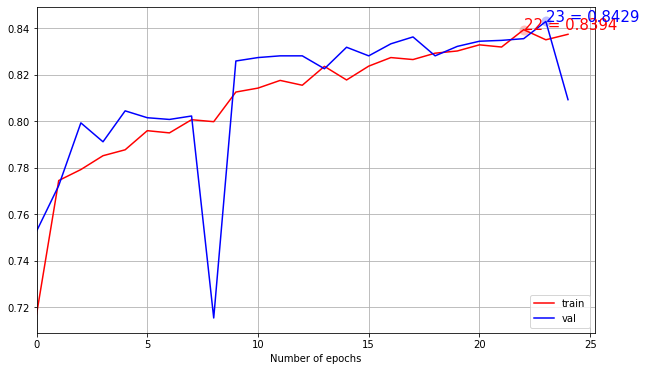

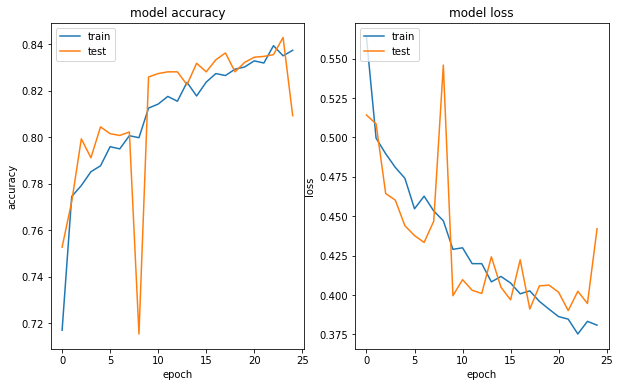

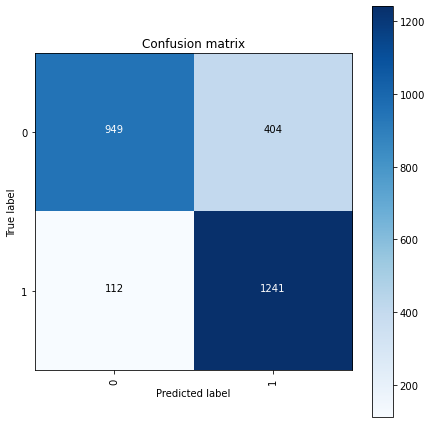

In [20]:
eval_model(build_base_CNN(),X_trainRus, Y_trainRus, X_testRus, Y_testRus, 'base_CNN', True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 48, 48, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)             

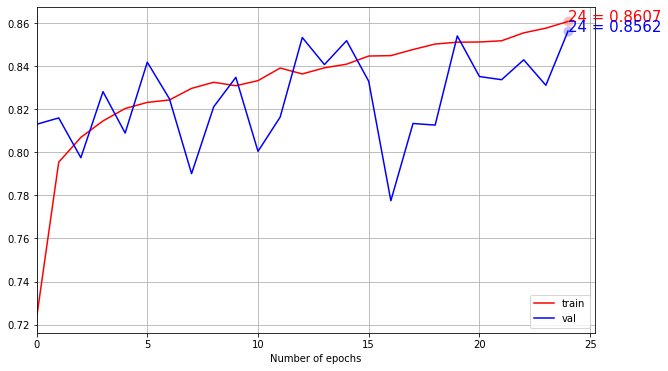

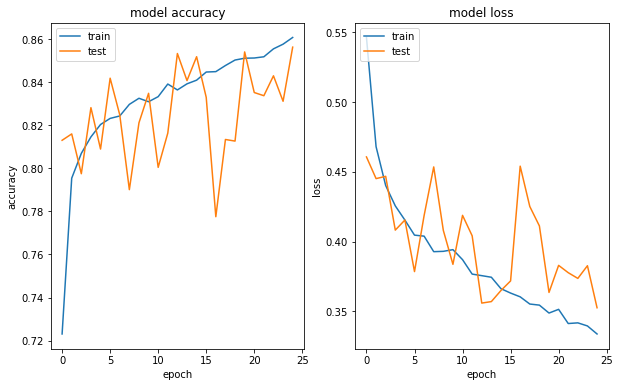

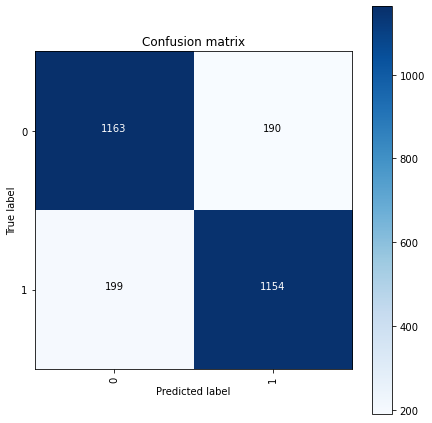

In [21]:
eval_model(build_final_CNN(),X_trainRus, Y_trainRus, X_testRus, Y_testRus, 'final_CNN', True)

In [23]:

base_cnnmodel = load_model('base_CNN.h5')
final_cnnmodel = load_model('final_CNN.h5')

In [25]:
#function to plot image
def img_plot(arr,index=0):
    plt.title('Test Image')
    plt.imshow(arr[index])
    

## Test Case 1

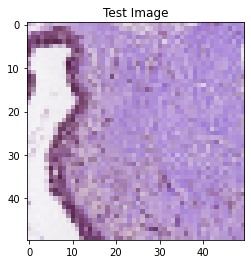

In [26]:
index1 = 51
img_plot(X_testRus, index1)

In [27]:
input1 = X_testRus[index1:index1+1]
print('Input Index =',index1)


Input Index = 51


In [28]:
label1 = Y_testRus[index1].argmax()
base_cnnpred1 = base_cnnmodel.predict(input1)[0].argmax()
final_cnnpred1 = final_cnnmodel.predict(input1)[0].argmax()


print('Predicted Value using base cnn model',base_cnnpred1)
print('Predicted Value using final cnn model',final_cnnpred1)

print("\nTrue Value",label1)

Predicted Value using base cnn model 1
Predicted Value using final cnn model 0

True Value 0


## Test Case 2

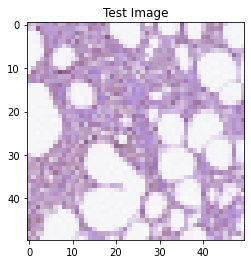

In [29]:
index2 = 402
img_plot(X_testRus, index2)

In [30]:
input2 = X_testRus[index2:index2+1]
print('Input Index =',index2)


Input Index = 402


In [31]:
label2 = Y_testRus[index2].argmax()
base_cnnpred2 = base_cnnmodel.predict(input2)[0].argmax()
final_cnnpred2 = final_cnnmodel.predict(input2)[0].argmax()


print('Predicted Value using base cnn model',base_cnnpred2)
print('Predicted Value using final cnn model',final_cnnpred2)
print("\nTrue Value",label2)

Predicted Value using base cnn model 1
Predicted Value using final cnn model 0

True Value 0
